In [4]:
import sys
import numpy
import warnings
from sklearn.decomposition import FastICA
warnings.filterwarnings("ignore")
sys.path.append("../")
from lib.metadata import MetadataListSiena
from lib.signals import EegProcessorSiena
from lib.spectral import FourierAnalysis
from lib.filters import FilterBank
from lib.stats import StatisticalTests
from lib.bss import IWasobi, EogDenoiser, CanonicalCorrelation, EmgDenoiser
from lib.visuals import plot_eeg_windows, plot_eeg_spectrum

### * Scales the EEG signal
### * Select a subset of the channels

Extracting EDF parameters from /mnt/c/Users/tobit/Downloads/eeg_datasets/siena/PN00/PN00-1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
2025-02-21 00:22:21,275 - root - INFO - Recording contains channels = ['EEG Fp1', 'EEG F3', 'EEG C3', 'EEG P3', 'EEG O1', 'EEG F7', 'EEG T3', 'EEG T5', 'EEG Fc1', 'EEG Fc5', 'EEG Cp1', 'EEG Cp5', 'EEG F9', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG Fp2', 'EEG F4', 'EEG C4', 'EEG P4', 'EEG O2', 'EEG F8', 'EEG T4', 'EEG T6', 'EEG Fc2', 'EEG Fc6', 'EEG Cp2', 'EEG Cp6', 'EEG F10', 'EKG EKG', 'SPO2', 'HR', '1', '2', 'MK']


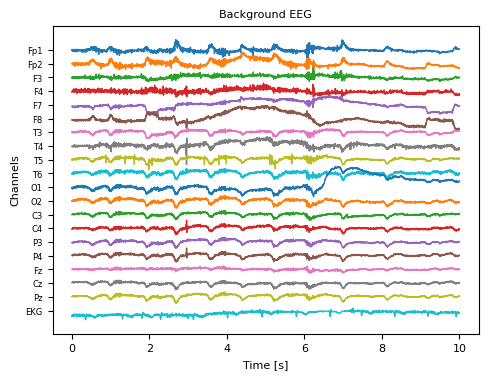

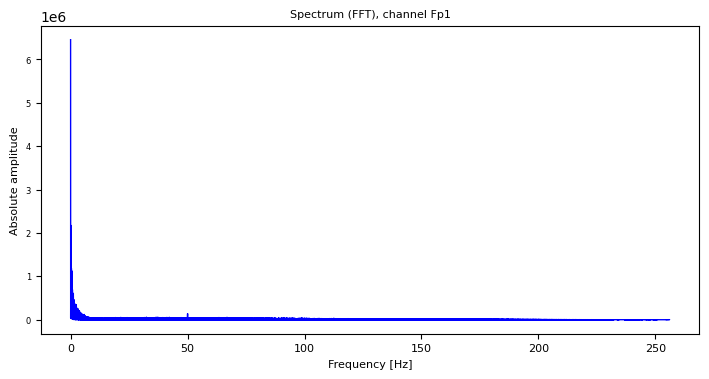

In [2]:
PATIENT = "PN00"
FILENAME = "PN00-1.edf"
PERIOD = [0, 10]

###########################################################
metadata = MetadataListSiena()
current_metadata = metadata.get(PATIENT, FILENAME)

###########################################################
processor = EegProcessorSiena(current_metadata["full_file"])
processor.select_channels()
processor.scale(ekg_reference=True)

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

###### DROP EKG CHANNELS FOR THE REST OF THE PROCESS ######
processor._data = processor._data[:-1]
processor.selected_channels = processor.selected_channels[:-1]

### * Re-referencing to average reference
Bug: if data is re-referenced, wasobi fails

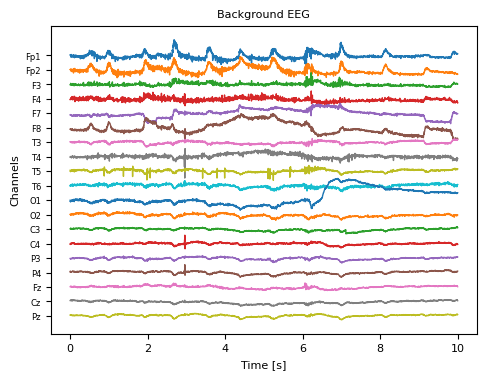

In [3]:
###########################################################
processor.rereference_to_average()

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Resample the EEG to 256Hz

2025-02-20 23:18:03,519 - root - INFO - Dowsampling factor is = 2


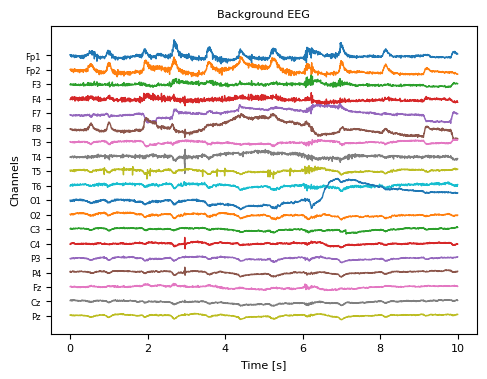

In [4]:
###########################################################
processor.resample()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

### * Remove the drift noise, high frequency oscillations, power line noise

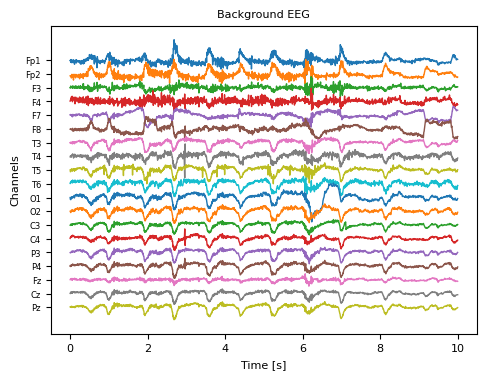

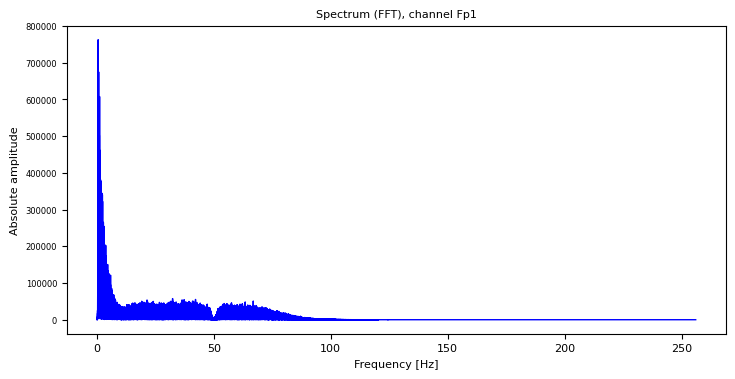

In [3]:
###########################################################
processor.filter_bank = FilterBank(0)
processor.remove_drift()
processor.remove_hfo()
processor.remove_power_noise()

###########################################################
fourier = FourierAnalysis(processor.sampling_frequency)
frequency_range, spectral_components = fourier.run_fast_fourier_transform(processor._data)

###########################################################
plot_eeg_windows(processor._data, current_metadata, processor.selected_channels, processor.sampling_frequency, PERIOD)

###########################################################
plot_eeg_spectrum(frequency_range, spectral_components, processor.selected_channels, "Fp1")

### * Separated sources using iWASOBI

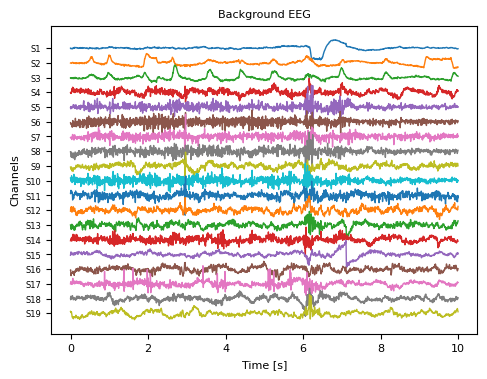

Source = 1, fd = 3.7233120667600264
Source = 2, fd = 4.250643776421148
Source = 3, fd = 4.338042867371273
Source = 4, fd = 5.7465925065282795
Source = 5, fd = 5.9615947645772565
Source = 6, fd = 6.266609083293719
Source = 7, fd = 6.118839394028465
Source = 8, fd = 6.12279771852031
Source = 9, fd = 5.409592227789607
Source = 10, fd = 6.304416461852634
Source = 11, fd = 5.9687480156724
Source = 12, fd = 5.4640619680802205
Source = 13, fd = 5.4340869752027325
Source = 14, fd = 6.02254624811416
Source = 15, fd = 4.836836578128766
Source = 16, fd = 5.34432493835597
Source = 17, fd = 5.790429595056358
Source = 18, fd = 5.449470718459278
Source = 19, fd = 4.9683910764829635
Done!
2025-02-20 23:19:55,892 - root - INFO - Number of sources to be removed = 3


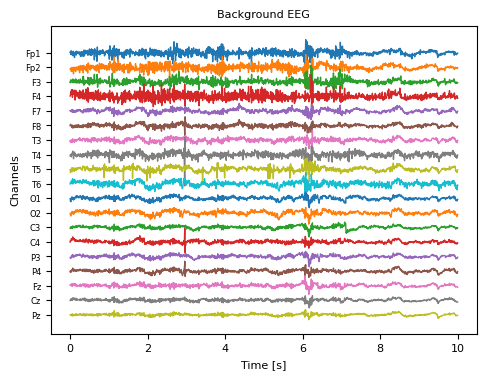

In [4]:
iwasobi = IWasobi()
eeg_sources = iwasobi.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                       PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eog_denoiser = EogDenoiser()
eog_denoiser.fit_fractal_dimensions(eeg_sources)
print(eog_denoiser)

eeg_sources = eog_denoiser.remove_low_dimension_sources([0, 3])
###########################################################

clean_eeg = iwasobi.inverse_transform(eeg_sources)

plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Separated sources using fastica

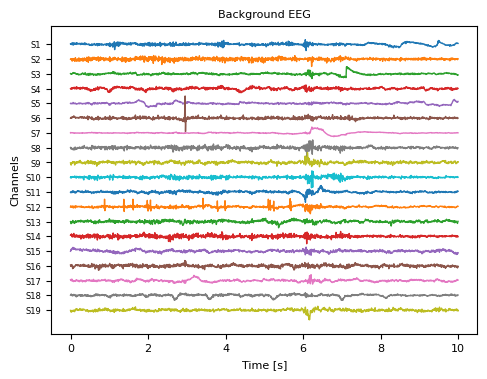

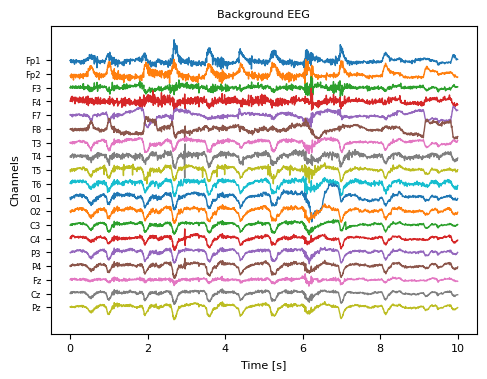

In [5]:
fastica = FastICA()
eeg_sources = fastica.fit_transform(numpy.transpose(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                                       PERIOD[1]*processor.sampling_frequency]))

###########################################################
plot_eeg_windows(numpy.transpose(eeg_sources), current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[1] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
eeg_sources[16, :] = 0
clean_eeg = fastica.inverse_transform(eeg_sources)
plot_eeg_windows(numpy.transpose(clean_eeg), current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Compute sources using BSS Canonical Correlation Analysis

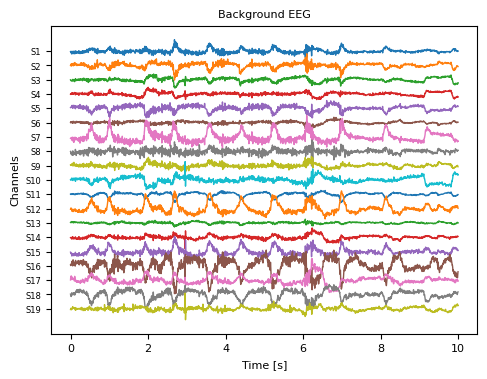

Source = 1, fd = 85.15321825958866
Source = 2, fd = 114.9980665556788
Source = 3, fd = 232.19005615662294
Source = 4, fd = 148.63216664690682
Source = 5, fd = 154.8983465581865
Source = 6, fd = 151.30131649194735
Source = 7, fd = 236.52017597624868
Source = 8, fd = 14.10019522584834
Source = 9, fd = 55.977115035997194
Source = 10, fd = 158.50321641084187
Source = 11, fd = 698.4923698565085
Source = 12, fd = 504.0394906922986
Source = 13, fd = 91.83371874113757
Source = 14, fd = 140.5172981184331
Source = 15, fd = 150.0359770032509
Source = 16, fd = 300.9543315416656
Source = 17, fd = 392.86739067430744
Source = 18, fd = 406.8781460162161
Source = 19, fd = 78.68337936736644
Done!
2025-02-20 23:21:12,385 - root - INFO - Number of sources to be removed = 0


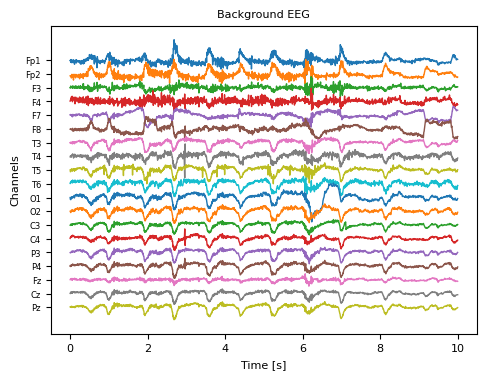

In [6]:
bsscca = CanonicalCorrelation()
eeg_sources = bsscca.fit_transform(processor._data[:, PERIOD[0]*processor.sampling_frequency:
                                                      PERIOD[1]*processor.sampling_frequency])

###########################################################
plot_eeg_windows(eeg_sources, current_metadata, [f"S{idx}" for idx in range(1, eeg_sources.shape[0] + 1)],
                 processor.sampling_frequency, period=[0, 10])

###########################################################
emg_denoiser = EmgDenoiser(sampling_frequency=processor.sampling_frequency)
emg_denoiser.fit_psd_ratio(eeg_sources)
print(emg_denoiser)

eeg_sources = emg_denoiser.remove_low_ratio_sources([0, 5])

###########################################################
clean_eeg = bsscca.inverse_transform(eeg_sources)
plot_eeg_windows(clean_eeg, current_metadata, processor.selected_channels,
                 processor.sampling_frequency, period=[0, 10])

### * Stationarity tests (KPPS and ADF)

In [7]:
stats_gateway = StatisticalTests()
stats_gateway.check_stationarity(processor._data[0, :2500])

2025-02-21 00:23:33,293 - root - INFO - KPSS test, null hyphotesis was not rejected, p_value = 0.1, significance level = 0.05
2025-02-21 00:23:33,349 - root - INFO - ADF test, null hyphotesis was rejected, p_value = 0.0005897008156189253, significance level = 0.05
2025-02-21 00:23:33,351 - root - INFO - The time serie is stationary


/mnt/c/Users/tobit/Documents/Doctorado/Initiative1_epic1/Project/code/notebooks/../lib/stats.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, _, _ = stattools.kpss(time_serie, regression="c")
